In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

In [2]:
class MelaData(Dataset):
    """MelaData dataset."""

    def __init__(self, data_dir, label_csv, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            data_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample: use prep1
        """
        
        self.data_dir = data_dir
        self.files = os.listdir(data_dir)
        
        labels = pd.read_csv(label_csv)
        dx_to_num = {'nv' : 0, 'mel': 1, 'bkl': 2, 'df': 3, 'akiec': 4, 'bcc': 5, 'vasc' : 6}        
        labels['label'] = labels['dx'].apply(lambda x: dx_to_num[x])
        self.labels = labels
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_name_with_extension = self.files[idx]
        image = Image.open(data_dir + image_name_with_extension)
        image_name = image_name_with_extension.strip('.jpg')
        
        if self.transform:
            image = self.transform(image)    
            
        label = self.labels.loc[self.labels['image_id'] == image_name, 'label']
        label = np.array(label)
        label_t = torch.from_numpy(label)
        return {'image': image, 'label': label_t}

In [3]:
#Define transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

prep1 = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ColorJitter(hue=.05, saturation=.05),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(360, resample=Image.BILINEAR),
                transforms.ToTensor(),
                normalize,
            ])

In [4]:
#Load a dataset
data_dir = 'data/images/train/'# Image File
label_csv = 'data/HAM10000_metadata.csv'

small_data = MelaData(data_dir=data_dir, label_csv=label_csv, transform=prep1)


In [5]:
#Create dataloader
dataloader = DataLoader(small_data, batch_size=4,shuffle=True, num_workers=4)

** Let's check it works **

In [6]:
#Helper function to show image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Helper function to show all images in a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size

    grid = utils.make_grid(images_batch)
    imshow(grid)

0 torch.Size([4, 3, 224, 224])
1 torch.Size([4, 3, 224, 224])


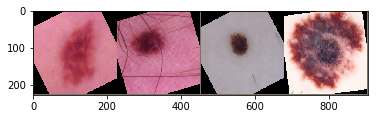

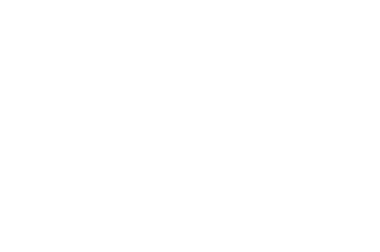

In [7]:
#Iterate over 2 first batches
#Print 1st batch size and show 2nd batch images
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 2nd batch and stop.
    if i_batch == 1:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break